### Pytania: 
1. W jaki sposób przetworzyć w tym przypadku dane kategorialne? Istnieje MCA, czyli PCA dla kategorialnych 
2. Jakie porównania robić między sobą
3. Czy badać pod kątem zbalansowania?
4. Czy użyć WEKI np. do porównania, czy warto

In [1]:
%matplotlib inline

In [2]:
import pandas as pd
from pathlib import Path 
from ydata_profiling import ProfileReport
import matplotlib.pyplot as plt
import prince
import numpy as np
import seaborn as sns
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, precision_score, recall_score, precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay
from ai_data_eng.machine_learning.viz import *
from ai_data_eng.machine_learning.utils import *
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.base import clone
from sklearn.feature_selection import SequentialFeatureSelector

DATA_DIR = Path("../../data")

In [3]:
dataset = pd.read_csv(DATA_DIR / 't-shirts.csv')

In [4]:
dataset.head()

size   material   color sleeves  demand
0    S      nylon   white    long  medium
1   XL  polyester   cream   short    high
2    S       silk    blue   short  medium
3    M     cotton   black   short  medium
4   XL  polyester  orange    long  medium

In [5]:
features = ['material', 'color', 'size', 'sleeves']

goal = 'demand'

labels = dataset[goal].drop_duplicates().values.tolist()
labels

['medium', 'high', 'low']

In [6]:
size_labels = ['XS', 'S', 'M' ,'L', 'XL', 'XXL', '3XL']
sleeves_labels = ['short', 'long']

## Eksploracja danych 

Dane są pełne i w całości kategorialne. Większość kategori, oprócz sleeves, jest niezbalansowanych. Będzie to prawdopodobnie miało wpływ na niektóre algorytmy. Jako że są to dane kategorialne, to jedyną ciekawą statystyką jest częstość występowania wartości w danych kategoriach, oraz korelacja (współwystępowanie) z innymi wartościami. Oprócz zmiennej którą chcemy przewidywać nie ma korelacji między atrybutami, co może być istotne w kontekście założeń niektóych algorytmów. 

Kategoria 'demand' jest zmienną, którą chcemy przewidzieć. 

In [7]:
profile = ProfileReport(dataset, title = "T Shirts Report")

In [8]:
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Rozkład cech z podziałem na przypisaną kategorię. Widać, że rozkłady różnią się dla wartości między kategoriami, tj. zapotrzebowanie jest różne ze względu na cechy ubrań.  

<Axes: xlabel='sleeves', ylabel='count'>

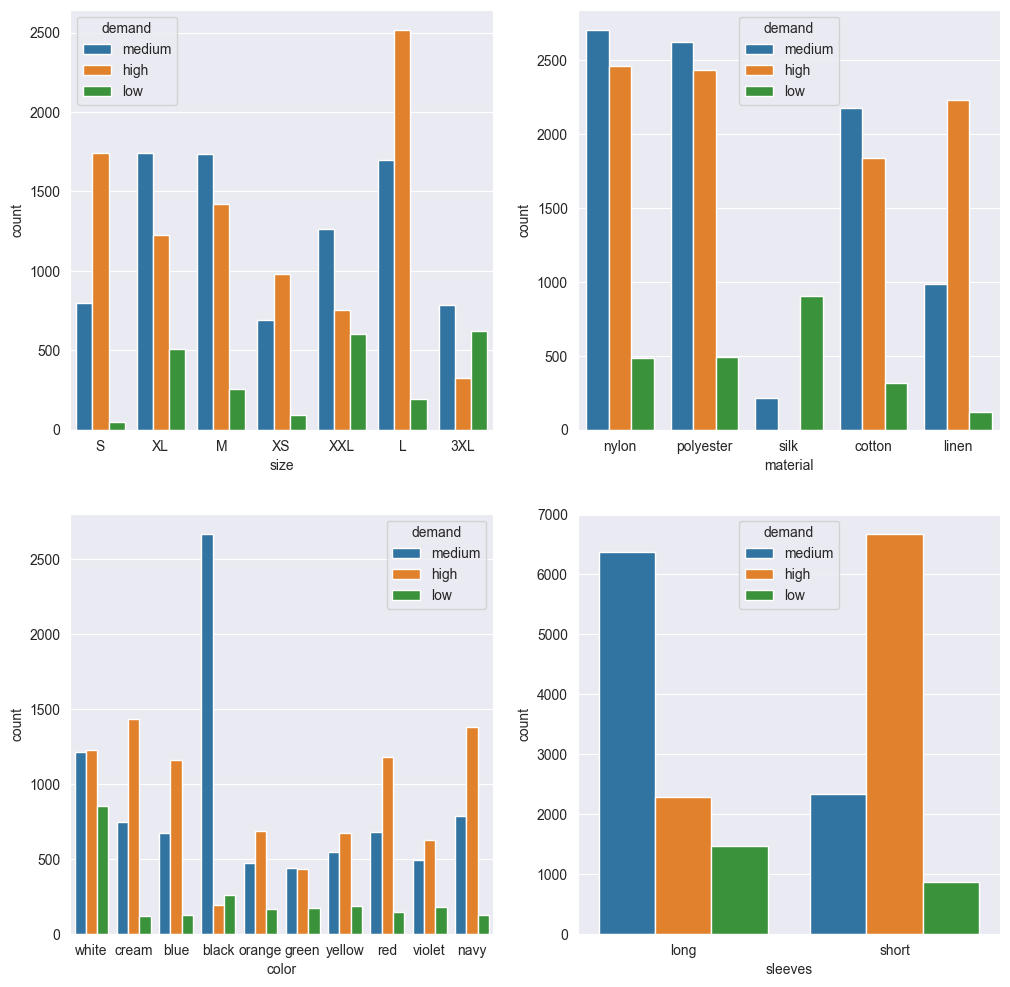

In [9]:
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
sns.countplot(dataset, x='size', hue=dataset[goal], ax=axes[0, 0])
sns.countplot(dataset, x='material', hue=dataset[goal], ax=axes[0, 1])
sns.countplot(dataset, x='color', hue=dataset[goal], ax=axes[1, 0])
sns.countplot(dataset, x='sleeves', hue=dataset[goal], ax=axes[1, 1])

Brak korelacji liniowej między zmiennymi nie musi określać jednoznacznie, że nie występują inne zależności. Jednak poniższe wykresy zdają się potwierdzać tezę o niezależności zmiennych, gdyż rozkłady kształtami są takie same/bardzo podobne dla jednej cechy, ze względu na drugą. 

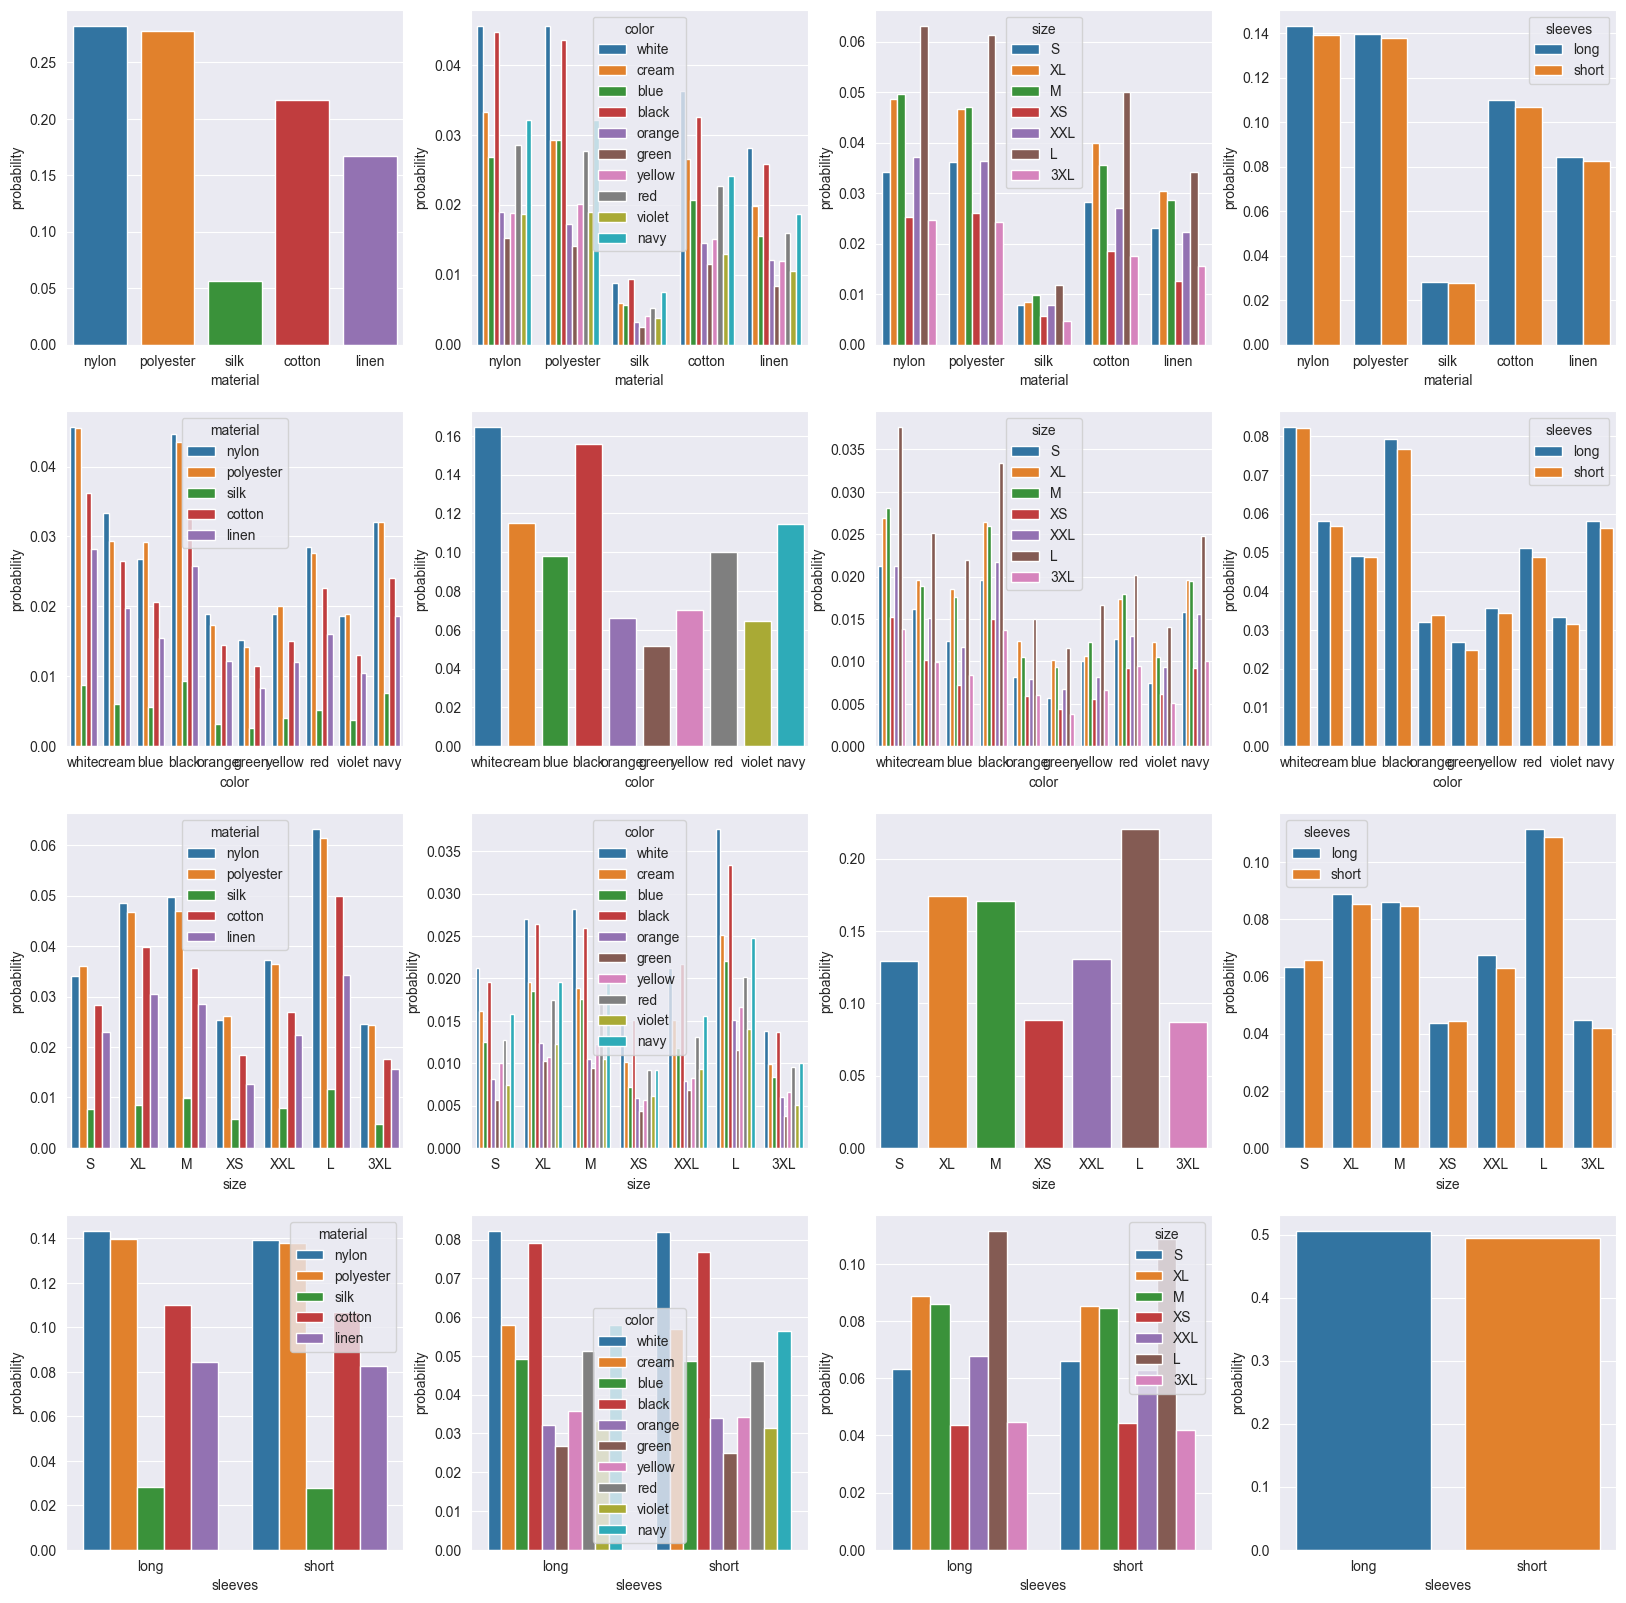

In [10]:
fig, axes = plt.subplots(4, 4, figsize=(20, 20))
flt_axes = axes.flatten()

for i in range(len(features)):
    for j in range(len(features)):
        sns.countplot(dataset, x=features[i], hue=features[j], stat='probability', ax=flt_axes[i * 4 + j], legend='auto')

### Podział danych na zbiory
Zbiór został podzielony na zbiory treningowy i testowy w proporcji 3:1

In [12]:
dataset.head()

size   material   color sleeves  demand
0    S      nylon   white    long  medium
1   XL  polyester   cream   short    high
2    S       silk    blue   short  medium
3    M     cotton   black   short  medium
4   XL  polyester  orange    long  medium

In [13]:
from sklearn.model_selection import train_test_split

# Could add stratification
train_dataset, test_dataset = train_test_split(dataset, test_size=0.25, stratify=dataset[goal], random_state=42)

In [14]:
print(f'{train_dataset.size}, {test_dataset.size}')

75000, 25000


Wykorzystany został podział z warstwami ze względu na liczność klas docelowych 

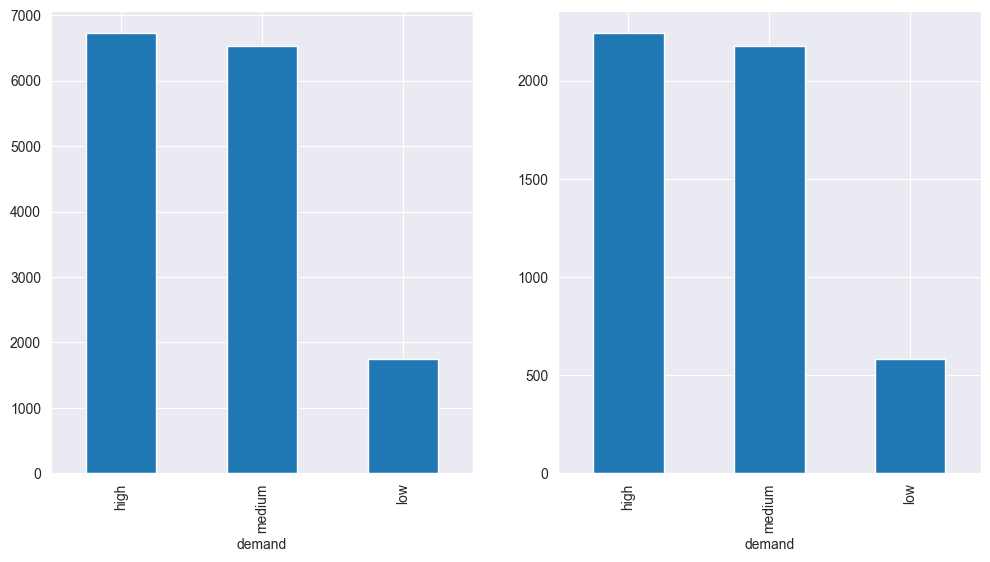

In [15]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
train_dataset[goal].value_counts().plot(kind='bar')
plt.subplot(1, 2, 2)
test_dataset[goal].value_counts().plot(kind='bar')
plt.show()

In [16]:
features_pipeline = Pipeline([
    ('encoder', OrdinalEncoder())
])

In [17]:
preprocessing_pipeline = ColumnTransformer([
    ('nominal_preprocessor', features_pipeline, features)
])

### Naiwny Bayes

In [119]:
from sklearn.naive_bayes import CategoricalNB

complete_pipeline = Pipeline([
    ('preprocessor', preprocessing_pipeline),
    ('estimator', CategoricalNB())
])

In [120]:
complete_pipeline.fit(train_dataset[features], train_dataset[goal])

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('nominal_preprocessor',
                                                  Pipeline(steps=[('encoder',
                                                                   OrdinalEncoder())]),
                                                  ['material', 'color', 'size',
                                                   'sleeves'])])),
                ('estimator', CategoricalNB())])

In [121]:
score = complete_pipeline.score(test_dataset[features], test_dataset[goal])

In [122]:
score

0.831

In [123]:
cat_nb_grid_search = GridSearchCV(estimator=CategoricalNB(),
                  param_grid={
                      'fit_prior': [True, False],
                      'class_prior': [None]
                  },
                  scoring=['accuracy', 'balanced_accuracy'], cv=5, verbose=1, refit='balanced_accuracy')

cat_nb_gs_pipeline = Pipeline([
    ('preprocessor', preprocessing_pipeline),
    ('estimator', cat_nb_grid_search)
])

cat_nb_gs_pipeline.fit(train_dataset[features], train_dataset[goal])

Fitting 5 folds for each of 2 candidates, totalling 10 fits


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('nominal_preprocessor',
                                                  Pipeline(steps=[('encoder',
                                                                   OrdinalEncoder())]),
                                                  ['material', 'color', 'size',
                                                   'sleeves'])])),
                ('estimator',
                 GridSearchCV(cv=5, estimator=CategoricalNB(),
                              param_grid={'class_prior': [None],
                                          'fit_prior': [True, False]},
                              refit='balanced_accuracy',
                              scoring=['accuracy', 'balanced_accuracy'],
                              verbose=1))])

#### Test znajdujący najlepsze cechy

In [146]:
ord_encoder = OrdinalEncoder()
X_enc = ord_encoder.fit_transform(train_dataset[features])

In [147]:
cat_nb_gs_pipeline.named_steps['estimator'].best_estimator_

CategoricalNB(fit_prior=False)

In [154]:
from sklearn.feature_selection import SequentialFeatureSelector

nb_feature_selector = SequentialFeatureSelector(
    estimator=clone(cat_nb_gs_pipeline.named_steps['estimator'].best_estimator_)
)

nb_feature_selector.fit(X_enc, train_dataset[goal])

SequentialFeatureSelector(estimator=CategoricalNB(fit_prior=False))

In [155]:
nb_feature_selector.get_feature_names_out(), nb_feature_selector.get_feature_names_out(features)

(array(['x0', 'x3'], dtype=object),
 array(['material', 'sleeves'], dtype=object))

In [166]:
sub_features = nb_feature_selector.get_feature_names_out(features)
subf_preprocessing_pipeline = ColumnTransformer([
    ('nominal_preprocessor', features_pipeline, sub_features)
])

cat_nb_subs_pipe = make_pipeline(
    subf_preprocessing_pipeline, CategoricalNB()
)

cat_nb_subs_pipe.fit(train_dataset[sub_features], train_dataset[goal])

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('nominal_preprocessor',
                                                  Pipeline(steps=[('encoder',
                                                                   OrdinalEncoder())]),
                                                  array(['material', 'sleeves'], dtype=object))])),
                ('categoricalnb', CategoricalNB())])

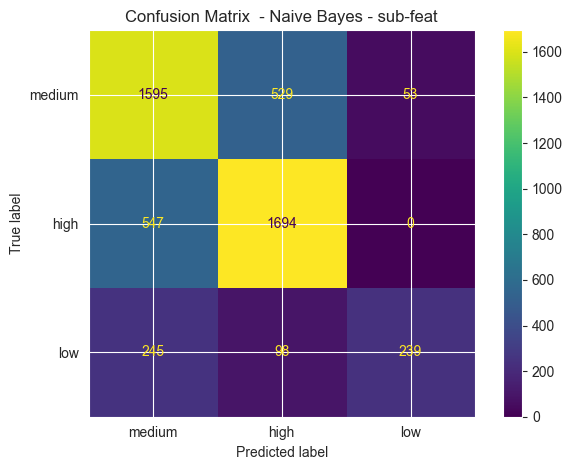

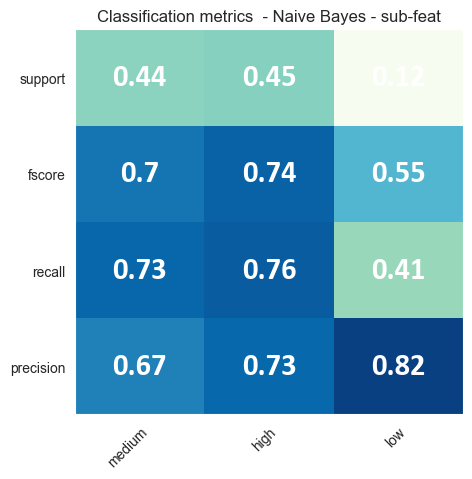

In [167]:
visualize_confusion_matrix(test_dataset[goal], cat_nb_subs_pipe.predict(test_dataset[features]), labels, 'Naive Bayes - sub-feat')
visualize_classification_metrics(test_dataset[goal], cat_nb_subs_pipe.predict(test_dataset[features]), labels, 'Naive Bayes - sub-feat')

In [168]:
cat_res = pd.DataFrame.from_dict(cat_nb_gs_pipeline.named_steps['estimator'].cv_results_)

In [24]:
cat_res[['param_class_prior', 'param_fit_prior', 'mean_test_accuracy', 'mean_test_balanced_accuracy']]

param_class_prior  param_fit_prior  mean_test_accuracy  \
0                NaN             True            0.811867   
1                NaN            False            0.815267   

   mean_test_balanced_accuracy  
0                     0.710542  
1                     0.829481

In [25]:
cat_nb_pipe_2 = Pipeline([
    ('preprocessor', preprocessing_pipeline),
    ('estimator', CategoricalNB(class_prior=None, fit_prior=True))
])

cat_nb_pipe_2.fit(train_dataset[features], train_dataset[goal])

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('nominal_preprocessor',
                                                  Pipeline(steps=[('encoder',
                                                                   OrdinalEncoder())]),
                                                  ['material', 'color', 'size',
                                                   'sleeves'])])),
                ('estimator', CategoricalNB())])

In [26]:
confusion_matrix(test_dataset[goal], cat_nb_gs_pipeline.predict(test_dataset[features]), labels=labels)

array([[1772,  112,  293],
       [ 309, 1848,   84],
       [  64,    0,  518]], dtype=int64)

In [27]:
class_accuracy(test_dataset[goal], cat_nb_gs_pipeline.predict(test_dataset[features]), labels)

array([0.81396417, 0.82463186, 0.89003436])

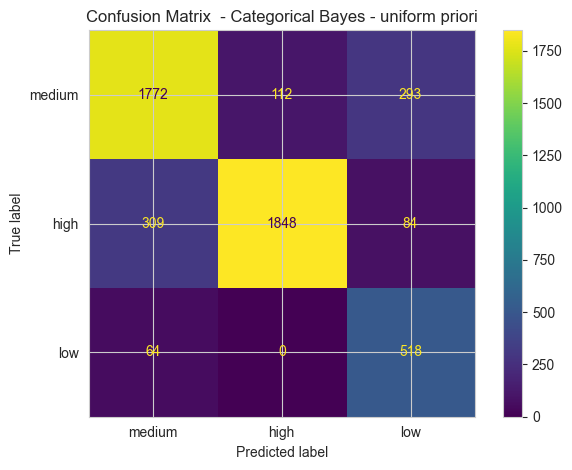

In [118]:
visualize_confusion_matrix(test_dataset[goal], cat_nb_gs_pipeline.predict(test_dataset[features]), labels, 'Categorical Bayes - uniform priori')

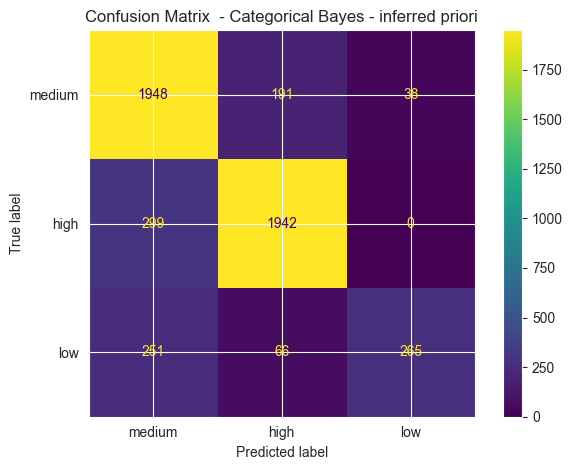

In [29]:
visualize_confusion_matrix(test_dataset[goal], cat_nb_pipe_2.predict(test_dataset[features]), labels, 'Categorical Bayes - inferred priori')

Między tymi dwoma algorytmami widać też zależność między recall a precision - jedno z nich jest bardziej dokładne kosztem drugiego. Widać również różnicę dla najmniej licznej klasy - w przypadku, gdy są używane jednakowe prawodopodbieństwa a priori, to klasa ta ma mniej pomyłek. 

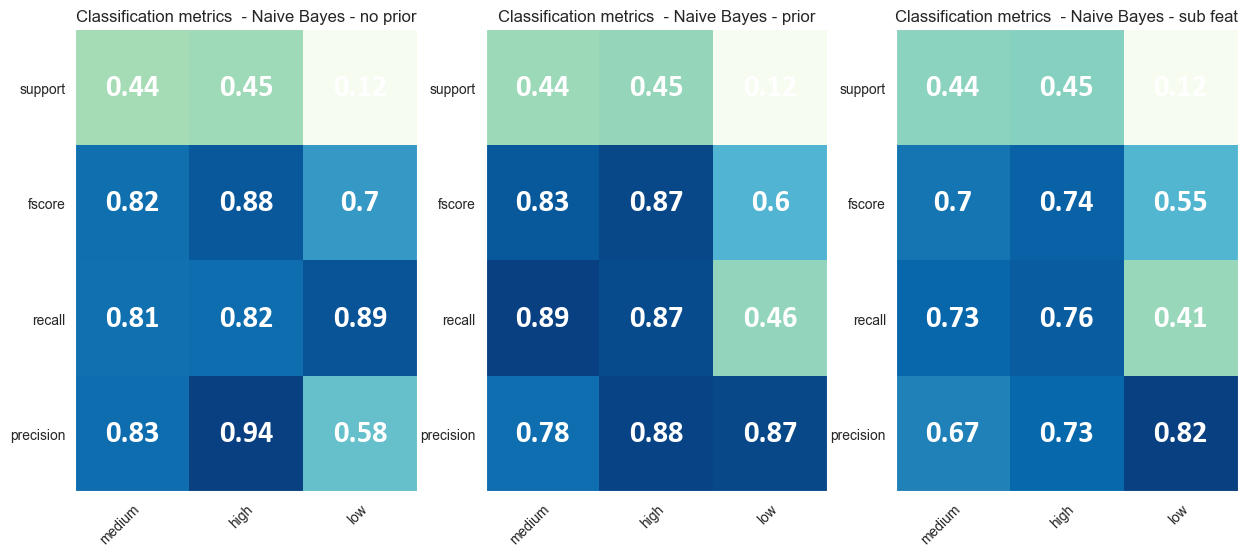

In [169]:
fig, axes = plt.subplots(1, 3, figsize=(15, 6))
visualize_classification_metrics(test_dataset[goal], cat_nb_gs_pipeline.predict(test_dataset[features]), labels, 'Naive Bayes - no prior', ax=axes[0])
visualize_classification_metrics(test_dataset[goal], cat_nb_pipe_2.predict(test_dataset[features]), labels, 'Naive Bayes - prior', ax=axes[1])
visualize_classification_metrics(test_dataset[goal], cat_nb_subs_pipe.predict(test_dataset[features]), labels, 'Naive Bayes - sub feat', ax=axes[2])

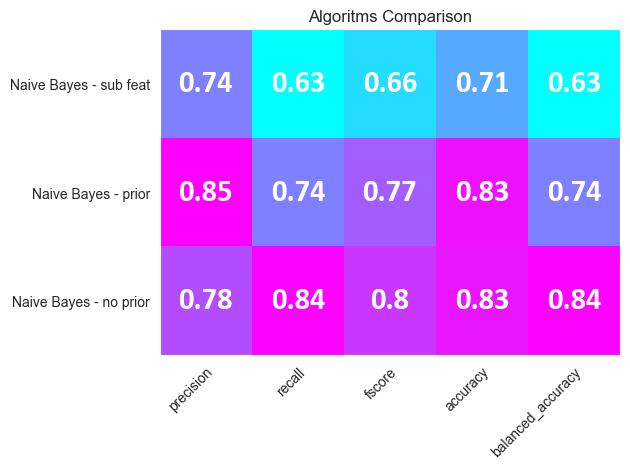

[0.7388512451890344,
 0.633075027780711,
 0.6628385918753918,
 0.7056,
 0.633075027780711]

In [170]:
visualize_compare_algorithms(test_dataset[features], test_dataset[goal],
                             [cat_nb_gs_pipeline, cat_nb_pipe_2, cat_nb_subs_pipe], names=['Naive Bayes - no prior', 'Naive Bayes - prior', 
                                                                         'Naive Bayes - sub feat'])

#### Naiwny Bayes z One Hot Encoding
Dla przetestowania zostanie również wykorzystana inna metoda kodowania. 

In [32]:
one_hot_pipeline = Pipeline([
    ('encoder', OneHotEncoder(sparse_output=False))
])

col_1h_pipeline = ColumnTransformer([
    ('1h_preprocessor', one_hot_pipeline, features)
])

cat_1h_grid_search = GridSearchCV(estimator=CategoricalNB(),
                  param_grid={
                      'alpha': [1.0, 0.5],
                      'fit_prior': [True, False],
                      'class_prior': [None, [0.5, 0.1, 0.4]]
                  },
                  scoring=['accuracy', 'balanced_accuracy'], cv=5, verbose=1, refit='balanced_accuracy')

cat_1h_gs_pipeline = Pipeline([
    ('preprocessor', col_1h_pipeline),
    ('estimator', cat_1h_grid_search)
])

cat_1h_gs_pipeline.fit(train_dataset[features], train_dataset[goal])

Fitting 5 folds for each of 8 candidates, totalling 40 fits


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('1h_preprocessor',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(sparse_output=False))]),
                                                  ['material', 'color', 'size',
                                                   'sleeves'])])),
                ('estimator',
                 GridSearchCV(cv=5, estimator=CategoricalNB(),
                              param_grid={'alpha': [1.0, 0.5],
                                          'class_prior': [None,
                                                          [0.5, 0.1, 0.4]],
                                          'fit_prior': [True, False]},
                              refit='balanced_accuracy',
                              scoring=['accuracy', 'balanced_accuracy'],
                              verbose=1))])

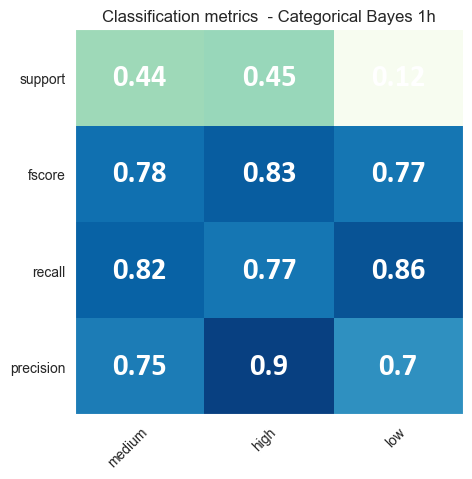

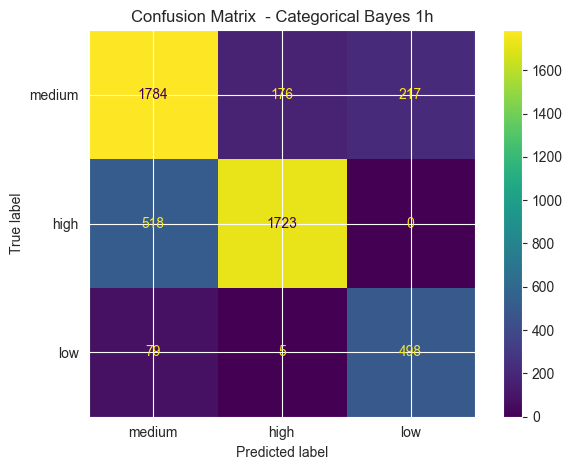

In [33]:
visualize_classification_metrics(test_dataset[goal], cat_1h_gs_pipeline.predict(test_dataset[features]), labels, 'Categorical Bayes 1h')
visualize_confusion_matrix(test_dataset[goal], cat_1h_gs_pipeline.predict(test_dataset[features]), labels, 'Categorical Bayes 1h')

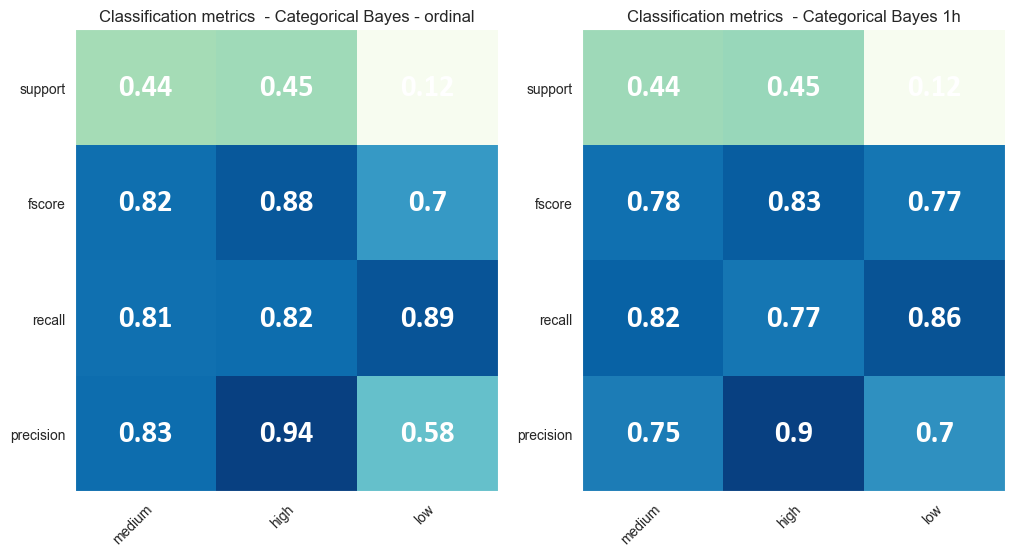

In [34]:
_, axes = plt.subplots(1, 2, figsize=(12, 6))
visualize_classification_metrics(test_dataset[goal], cat_nb_gs_pipeline.predict(test_dataset[features]), labels, 'Categorical Bayes - ordinal', ax=axes[0])
visualize_classification_metrics(test_dataset[goal], cat_1h_gs_pipeline.predict(test_dataset[features]), labels, 'Categorical Bayes 1h', ax=axes[1])

Naiwny bayes z kodowaniem 'ordinal' osiąga 2 razy więcej lepszych metryk, jednak jest gorszy dla klasy 'medium'  

In [36]:
has_better_metrics(test_dataset[features], test_dataset[goal], cat_nb_gs_pipeline, cat_1h_gs_pipeline, precision_recall_fscore_support)

array([[ 1., -1.,  1.],
       [ 1.,  1., -1.],
       [ 1., -1.,  1.],
       [ 0.,  0.,  0.]])

### Drzewo decyzyjne

In [37]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
dt_clf_pipe = Pipeline([
    ('preprocessor', preprocessing_pipeline),
    ('estimator', DecisionTreeClassifier(random_state=42))
])

dt_clf_pipe.fit(train_dataset[features], train_dataset[goal])

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('nominal_preprocessor',
                                                  Pipeline(steps=[('encoder',
                                                                   OrdinalEncoder())]),
                                                  ['material', 'color', 'size',
                                                   'sleeves'])])),
                ('estimator', DecisionTreeClassifier(random_state=42))])

In [38]:
precision_recall_fscore_support(test_dataset[goal], dt_clf_pipe.predict(test_dataset[features]), labels=labels)

(array([0.96303058, 0.9821269 , 0.95271454]),
 array([0.9692237 , 0.98081214, 0.9347079 ]),
 array([0.96611722, 0.98146908, 0.94362533]),
 array([2177, 2241,  582], dtype=int64))

In [39]:
clf = dt_clf_pipe.named_steps['estimator']
clf

DecisionTreeClassifier(random_state=42)

In [40]:
clf.tree_.max_depth

17

[Text(0.6245899283008658, 0.9722222222222222, 'x[3] <= 0.5\ngini = 0.596\nsamples = 15000\nvalue = [6724, 1744, 6532]'),
 Text(0.41882271374458874, 0.9166666666666666, 'x[0] <= 3.5\ngini = 0.536\nsamples = 7588\nvalue = [1737, 1109, 4742]'),
 Text(0.5217063210227273, 0.9444444444444444, 'True  '),
 Text(0.1774722673160173, 0.8611111111111112, 'x[2] <= 0.5\ngini = 0.509\nsamples = 7164\nvalue = [1737, 783, 4644]'),
 Text(0.06168831168831169, 0.8055555555555556, 'x[1] <= 4.5\ngini = 0.5\nsamples = 617\nvalue = [0, 314, 303]'),
 Text(0.030303030303030304, 0.75, 'x[0] <= 1.5\ngini = 0.426\nsamples = 312\nvalue = [0, 96, 216]'),
 Text(0.017316017316017316, 0.6944444444444444, 'x[0] <= 0.5\ngini = 0.5\nsamples = 132\nvalue = [0, 64, 68]'),
 Text(0.008658008658008658, 0.6388888888888888, 'x[1] <= 0.5\ngini = 0.494\nsamples = 63\nvalue = [0, 35, 28]'),
 Text(0.004329004329004329, 0.5833333333333334, 'gini = 0.0\nsamples = 28\nvalue = [0, 0, 28]'),
 Text(0.012987012987012988, 0.5833333333333334

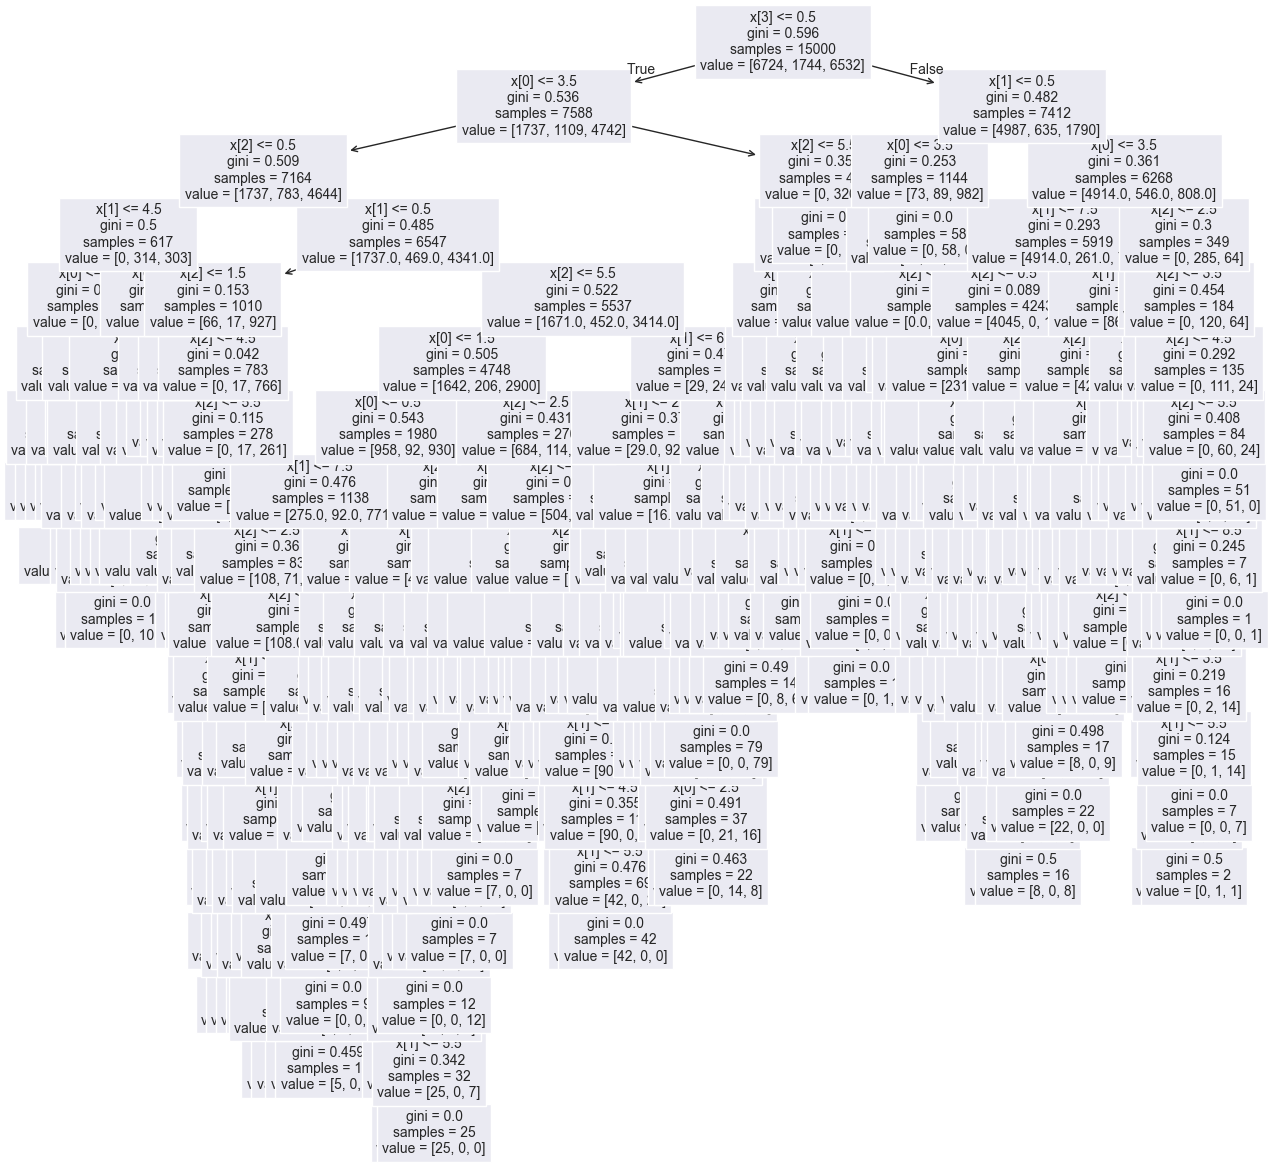

In [41]:
fig, ax = plt.subplots(figsize=(15, 15))
plot_tree(clf, ax=ax, fontsize=10)

In [171]:
from sklearn.tree import DecisionTreeClassifier

dt_clf_grid_search = GridSearchCV(estimator=DecisionTreeClassifier(random_state=42),
                  param_grid={
                      'criterion': ['gini', 'entropy'],
                      'max_depth': [None, 6, 12],
                      'min_samples_leaf': [1, 2, 5],
                      'max_features': [None, 'log2']
                  },
                  scoring=['accuracy', 'balanced_accuracy'], cv=5, verbose=1, refit='balanced_accuracy')

dt_clf_gd_pipe = Pipeline([
    ('preprocessor', preprocessing_pipeline),
    ('estimator', dt_clf_grid_search)
])

dt_clf_gd_pipe.fit(train_dataset[features], train_dataset[goal])

Fitting 5 folds for each of 36 candidates, totalling 180 fits


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('nominal_preprocessor',
                                                  Pipeline(steps=[('encoder',
                                                                   OrdinalEncoder())]),
                                                  ['material', 'color', 'size',
                                                   'sleeves'])])),
                ('estimator',
                 GridSearchCV(cv=5,
                              estimator=DecisionTreeClassifier(random_state=42),
                              param_grid={'criterion': ['gini', 'entropy'],
                                          'max_depth': [None, 6, 12],
                                          'max_features': [None, 'log2'],
                                          'min_samples_leaf': [1, 2, 5]},
                              refit='balanced_accuracy',
                              scoring=['accuracy', 'balanced_accuracy'],
                              verbose=1))])

In [172]:
dt_res = pd.DataFrame.from_dict(dt_clf_gd_pipe.named_steps['estimator'].cv_results_)

In [173]:
dt_res.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_criterion', 'param_max_depth', 'param_max_features',
       'param_min_samples_leaf', 'params', 'split0_test_accuracy',
       'split1_test_accuracy', 'split2_test_accuracy', 'split3_test_accuracy',
       'split4_test_accuracy', 'mean_test_accuracy', 'std_test_accuracy',
       'rank_test_accuracy', 'split0_test_balanced_accuracy',
       'split1_test_balanced_accuracy', 'split2_test_balanced_accuracy',
       'split3_test_balanced_accuracy', 'split4_test_balanced_accuracy',
       'mean_test_balanced_accuracy', 'std_test_balanced_accuracy',
       'rank_test_balanced_accuracy'],
      dtype='object')

#### Analiza wyników przeszukiwania

Najlepsze wyniki (> 0.96) osiągnęły drzewa o maksymalnej możliwej głębokości (tutaj to mogło być 17). Następnie gorsze wyniki mają drzewa z większymi liśćmi. Po piętach depczą im drzewa o mniejszej maksymalnej głębokości (12) o wynikach ok. 0.95. Dla maksymalnej głębokości 6 wyniki są już drastycznie gorsze, bo poniżej 0.8. 

In [175]:
dt_res[['param_criterion','param_max_depth', 'param_max_features', 'param_min_samples_leaf',
       'mean_test_accuracy', 'mean_test_balanced_accuracy']]

param_criterion  param_max_depth param_max_features  \
0             gini              NaN               None   
1             gini              NaN               None   
2             gini              NaN               None   
3             gini              NaN               log2   
4             gini              NaN               log2   
5             gini              NaN               log2   
6             gini              6.0               None   
7             gini              6.0               None   
8             gini              6.0               None   
9             gini              6.0               log2   
10            gini              6.0               log2   
11            gini              6.0               log2   
12            gini             12.0               None   
13            gini             12.0               None   
14            gini             12.0               None   
15            gini             12.0               log2   
16            gini             12.0               log2   
17            gini             12.0               log2   
18         entropy              NaN               None   
19         entropy              NaN               None   
20         entropy              NaN               None   
21         entropy              NaN               log2   
22         entropy              NaN               log2   
23         entropy              NaN               log2   
24         entropy              6.0               None   
25         entropy              6.0               None   
26         entropy              6.0               None   
27         entropy              6.0               log2   
28         entropy              6.0               log2   
29         entropy              6.0               log2   
30         entropy             12.0               None   
31         entropy             12.0               None   
32         entropy             12.0               None   
33         entropy             12.0               log2   
34         entropy             12.0               log2   
35         entropy             12.0               log2   

    param_min_samples_leaf  mean_test_accuracy  mean_test_balanced_accuracy  
0                        1            0.967200                     0.960783  
1                        2            0.967000                     0.960350  
2                        5            0.965600                     0.958868  
3                        1            0.966800                     0.959917  
4                        2            0.966067                     0.958656  
5                        5            0.964067                     0.956151  
6                        1            0.798733                     0.742445  
7                        2            0.798733                     0.742445  
8                        5            0.798733                     0.742445  
9                        1            0.796733                     0.719444  
10                       2            0.796600                     0.719062  
11                       5            0.796533                     0.718871  
12                       1            0.959000                     0.950340  
13                       2            0.958800                     0.949907  
14                       5            0.958267                     0.949083  
15                       1            0.955067                     0.944330  
16                       2            0.954600                     0.943133  
17                       5            0.951400                     0.938203  
18                       1            0.967200                     0.960783  
19                       2            0.967267                     0.960834  
20                       5            0.966133                     0.959972  
21                       1            0.966667                     0.959675  
22                       2            0.965933                

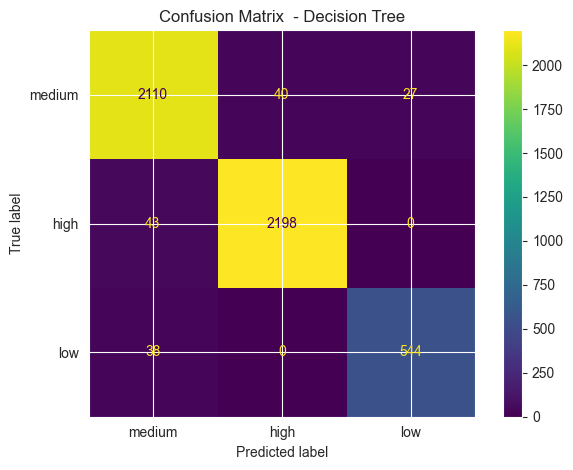

In [176]:
visualize_confusion_matrix(test_dataset[goal], dt_clf_gd_pipe.predict(test_dataset[features]), labels=labels, name='Decision Tree')

Klasa o najmniejszej liczności ma trochę gorsze metryki

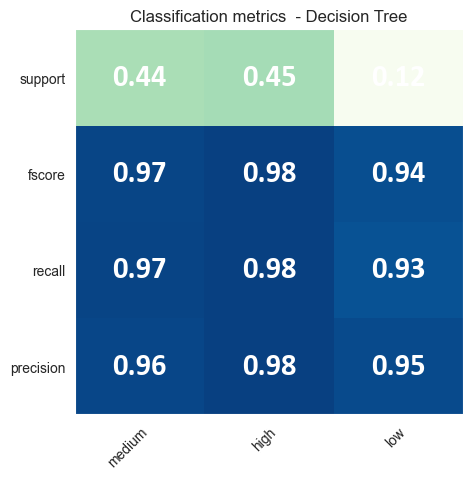

In [177]:
visualize_classification_metrics(test_dataset[goal], dt_clf_gd_pipe.predict(test_dataset[features]), labels=labels, name='Decision Tree')

In [178]:
dt_1h_grid_search = GridSearchCV(estimator=DecisionTreeClassifier(random_state=42),
                  param_grid={
                      'max_depth': [None, 6, 12],
                      'min_samples_leaf': [1, 2, 5],
                      'max_features': [None, 'log2']
                  },
                  scoring=['accuracy', 'balanced_accuracy'], cv=5, verbose=1, refit='balanced_accuracy')


one_hot_pipeline = Pipeline([
    ('encoder', OneHotEncoder(sparse_output=False))
])

col_1h_pipeline = ColumnTransformer([
    ('1h_preprocessor', one_hot_pipeline, features)
])

dt_1h_gd_pipe = Pipeline([
    ('preprocessor', col_1h_pipeline),
    ('estimator', dt_1h_grid_search)
])

dt_1h_gd_pipe.fit(train_dataset[features], train_dataset[goal])

Fitting 5 folds for each of 18 candidates, totalling 90 fits


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('1h_preprocessor',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(sparse_output=False))]),
                                                  ['material', 'color', 'size',
                                                   'sleeves'])])),
                ('estimator',
                 GridSearchCV(cv=5,
                              estimator=DecisionTreeClassifier(random_state=42),
                              param_grid={'max_depth': [None, 6, 12],
                                          'max_features': [None, 'log2'],
                                          'min_samples_leaf': [1, 2, 5]},
                              refit='balanced_accuracy',
                              scoring=['accuracy', 'balanced_accuracy'],
                              verbose=1))])

In [179]:
dt_1h_res = pd.DataFrame.from_dict(dt_1h_gd_pipe.named_steps['estimator'].cv_results_)

In [180]:
dt_1h_res[['param_max_depth', 'param_max_features', 'param_min_samples_leaf',
       'mean_test_accuracy', 'mean_test_balanced_accuracy']]

param_max_depth param_max_features  param_min_samples_leaf  \
0               NaN               None                       1   
1               NaN               None                       2   
2               NaN               None                       5   
3               NaN               log2                       1   
4               NaN               log2                       2   
5               NaN               log2                       5   
6               6.0               None                       1   
7               6.0               None                       2   
8               6.0               None                       5   
9               6.0               log2                       1   
10              6.0               log2                       2   
11              6.0               log2                       5   
12             12.0               None                       1   
13             12.0               None                       2   
14             12.0               None                       5   
15             12.0               log2                       1   
16             12.0               log2                       2   
17             12.0               log2                       5   

    mean_test_accuracy  mean_test_balanced_accuracy  
0             0.967267                     0.960834  
1             0.967133                     0.960872  
2             0.965333                     0.957973  
3             0.967200                     0.960923  
4             0.966333                     0.958298  
5             0.962733                     0.953033  
6             0.848000                     0.823773  
7             0.848000                     0.823773  
8             0.848000                     0.823773  
9             0.687000                     0.633163  
10            0.686867                     0.632781  
11            0.686733                     0.631699  
12            0.964133                     0.957464  
13            0.964000                     0.957502  
14            0.963067                     0.955260  
15            0.895533                     0.880784  
16            0.895533                     0.881064  
17            0.894000                     0.876390

Zmiana kodowania w przypadku drzewa decyzyjnego nie miała wpływu na wyniki. 

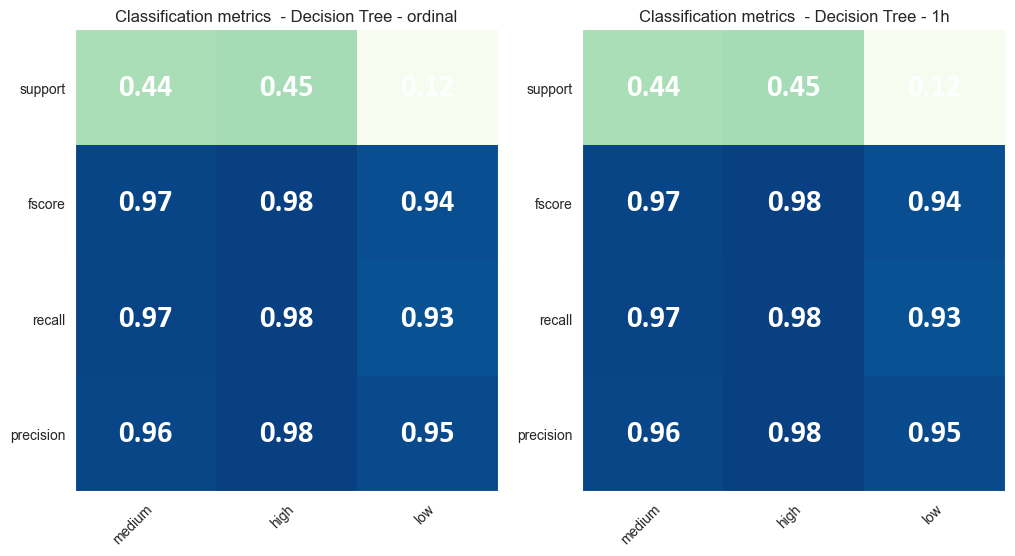

In [51]:
_, axes = plt.subplots(1, 2, figsize=(12, 6))
visualize_classification_metrics(test_dataset[goal], dt_clf_gd_pipe.predict(test_dataset[features]), labels=labels, name='Decision Tree - ordinal', ax=axes[0])
visualize_classification_metrics(test_dataset[goal], dt_1h_gd_pipe.predict(test_dataset[features]), labels=labels, name='Decision Tree - 1h', ax=axes[1])

### MCA & SVC

In [52]:
mca_dim = 6

mca = prince.MCA(
    n_components=mca_dim,
    n_iter=6,
    copy=True,
    check_input=True,
    engine='sklearn',
    random_state=42
)
mca.fit_transform(train_dataset[features])

0         1         2         3         4         5
3152   0.128345 -0.583597  0.852559  0.617349 -0.007013  0.232564
2950  -0.431268  0.094435  0.291769  0.244947 -0.114913 -0.175820
7761  -0.327130  0.069008 -0.329152 -0.347512 -0.119943  0.997347
11332  0.059775  0.144256  0.463554  0.322576 -0.472787 -0.406133
1172   0.454915 -0.307624 -0.660681 -0.703521 -0.326280 -0.760889
...         ...       ...       ...       ...       ...       ...
17606 -0.147986  0.882272  0.599039  0.225143  0.314971 -0.079137
8605  -0.438945 -0.847942 -0.553249  0.130691 -0.159186  0.405901
1078  -0.070557  0.229762 -0.379122 -0.670177  0.372523 -0.100839
8096  -0.239973 -0.377769 -0.314721 -0.431747 -0.918702 -0.585697
8119  -0.949644  0.277302 -0.112161  0.940787 -0.210719 -0.601758

[15000 rows x 6 columns]

In [53]:
mca.transform(test_dataset[features])

0         1         2         3         4         5
19917 -0.553661 -0.246769 -0.887564  0.450054  0.554468 -0.555208
14440  0.467139 -0.723342  0.062837 -0.023687  0.142002 -0.270733
8865   0.863003 -0.200206  0.063268  0.143964 -0.069655 -0.690818
13489 -0.434699 -0.148426 -0.452436 -0.954635 -0.868548  0.265106
9345  -0.087681 -0.407018  0.075889 -0.583798 -0.386336  0.321866
...         ...       ...       ...       ...       ...       ...
9292  -0.527381 -0.035369  0.018538  0.299535  0.334194 -0.027035
12292  0.298509 -0.189646 -0.362200 -0.258595  0.354836  0.568470
16395  0.762621  0.923564 -0.405161  0.601172 -0.411829 -0.116890
10583  0.419869  0.057276  0.312788  0.359799  0.105705 -0.147930
19253  0.225523  1.028765  0.330880 -0.292227  1.281320 -0.436426

[5000 rows x 6 columns]

In [54]:
mca.eigenvalues_summary

eigenvalue % of variance % of variance (cumulative)
component                                                    
0              0.262         5.24%                      5.24%
1              0.261         5.21%                     10.45%
2              0.258         5.17%                     15.62%
3              0.256         5.13%                     20.75%
4              0.255         5.09%                     25.84%
5              0.254         5.08%                     30.92%

In [55]:
mca.row_coordinates(train_dataset[features]).head()

0         1         2         3         4         5
3152   0.128345 -0.583597  0.852559  0.617349 -0.007013  0.232564
2950  -0.431268  0.094435  0.291769  0.244947 -0.114913 -0.175820
7761  -0.327130  0.069008 -0.329152 -0.347512 -0.119943  0.997347
11332  0.059775  0.144256  0.463554  0.322576 -0.472787 -0.406133
1172   0.454915 -0.307624 -0.660681 -0.703521 -0.326280 -0.760889

In [191]:
mca_train_dataset = pd.merge(train_dataset[goal], mca.row_coordinates(train_dataset[features]), left_index=True, right_index=True)
mca_train_dataset[goal]

3152       high
2950     medium
7761     medium
11332    medium
1172     medium
          ...  
17606      high
8605     medium
1078       high
8096       high
8119     medium
Name: demand, Length: 15000, dtype: object

<Axes: xlabel='0', ylabel='5'>

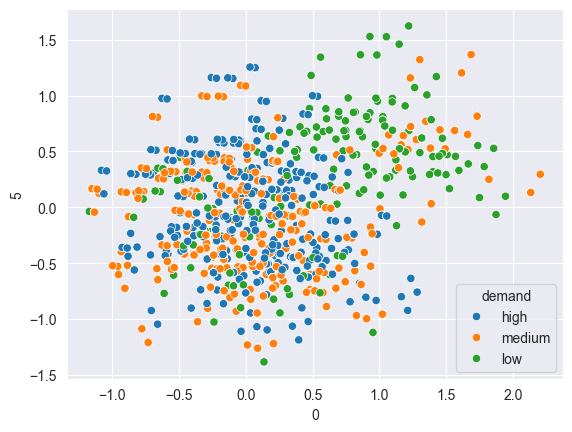

In [57]:
sns.scatterplot(mca_train_dataset, x=0, y=5, hue='demand')

In [58]:
mca.row_coordinates(train_dataset[features])

0         1         2         3         4         5
3152   0.128345 -0.583597  0.852559  0.617349 -0.007013  0.232564
2950  -0.431268  0.094435  0.291769  0.244947 -0.114913 -0.175820
7761  -0.327130  0.069008 -0.329152 -0.347512 -0.119943  0.997347
11332  0.059775  0.144256  0.463554  0.322576 -0.472787 -0.406133
1172   0.454915 -0.307624 -0.660681 -0.703521 -0.326280 -0.760889
...         ...       ...       ...       ...       ...       ...
17606 -0.147986  0.882272  0.599039  0.225143  0.314971 -0.079137
8605  -0.438945 -0.847942 -0.553249  0.130691 -0.159186  0.405901
1078  -0.070557  0.229762 -0.379122 -0.670177  0.372523 -0.100839
8096  -0.239973 -0.377769 -0.314721 -0.431747 -0.918702 -0.585697
8119  -0.949644  0.277302 -0.112161  0.940787 -0.210719 -0.601758

[15000 rows x 6 columns]

In [59]:
mca.column_coordinates(train_dataset[features])

0         1         2         3         4         5
material_cotton    -0.382733 -0.032877 -0.519306 -0.326102  0.158643  0.538576
material_linen      0.064199  1.210551  0.228234  0.555174 -0.123989 -0.598514
material_nylon     -0.304651 -0.280514  0.490419 -0.034301  0.121661  0.527346
material_polyester  0.160985 -0.383425 -0.279962 -0.221418 -0.050717 -0.845977
material_silk       2.043546 -0.192355  0.288162  0.891092 -0.609306  1.280552
color_black         0.490356 -0.428467  0.895105  0.184174 -0.017186 -0.231434
color_blue         -0.107172 -0.509586 -1.186512  0.384302  0.636829  0.088785
color_cream         0.145077  0.661309  0.030925 -0.291535  0.412450  1.459666
color_green        -0.821185 -1.033440 -0.118169  0.601488 -0.834538 -0.252484
color_navy          0.236597  0.154472 -0.524836  1.287677 -0.526524  0.347720
color_orange       -0.780057  1.339848  0.906635 -0.780447 -0.421148  0.160496
color_red          -0.331661 -0.135531  0.375527 -0.266332  1.492856  0.101469
color_violet       -0.464766 -0.500818  0.498330  0.655049  0.342440 -1.230451
color_white        -0.220183  0.099564 -0.179078 -0.566803 -0.990601 -0.345813
color_yellow        1.202641  0.242795 -0.882479 -1.117170  0.205287 -0.698848
size_3XL            0.655880  0.966088  0.089546 -0.397924  1.272356 -0.549304
size_L             -0.360509 -0.429333 -0.200936 -0.557610 -0.866638  0.174562
size_M              0.231798 -0.724699 -0.466816  0.471979  0.409248  0.364954
size_S              1.187360  0.461271 -0.506598 -0.142723 -0.126129 -0.151650
size_XL            -1.115813  0.447311 -0.358198  0.277007  0.479737 -0.198597
size_XS             0.402501 -1.007442  1.747737 -0.474697  0.337282 -0.243395
size_XXL           -0.108901  0.666958  0.634763  0.649795 -0.678359  0.170679
sleeves_long       -0.071653 -0.058188  0.020090  0.471506  0.053424 -0.163025
sleeves_short       0.073354  0.059570 -0.020567 -0.482702 -0.054693  0.166896

In [60]:
import altair as alt
alt.data_transformers.enable("vegafusion")

mca.plot(
    train_dataset[features],
    x_component=0,
    y_component=1,
    show_column_markers=True,
    show_row_markers=True,
    show_column_labels=False,
    show_row_labels=False
)

alt.LayerChart(...)

In [61]:
mca.column_contributions_.head().style.format('{:.0%}')

In [62]:
mca.row_cosine_similarities(train_dataset[features]).head()

0         1         2         3         4         5
3152   0.003084  0.063757  0.136067  0.071345  0.000009  0.010125
2950   0.028955  0.001388  0.013253  0.009341  0.002056  0.004813
7761   0.026738  0.001190  0.027070  0.030174  0.003594  0.248531
11332  0.000952  0.005544  0.057250  0.027723  0.059553  0.043945
1172   0.040723  0.018622  0.085895  0.097395  0.020949  0.113926

In [63]:
mca.column_cosine_similarities(train_dataset[features]).head()

0         1         2         3         4         5
material_cotton     0.040948  0.000302  0.075385  0.029727  0.007035  0.081083
material_linen      0.000831  0.295482  0.010503  0.062147  0.003100  0.072229
material_nylon      0.036046  0.030560  0.093408  0.000457  0.005749  0.108005
material_polyester  0.010009  0.056776  0.030269  0.018933  0.000993  0.276390
material_silk       0.244924  0.002170  0.004870  0.046570  0.021774  0.096174

In [64]:
from sklearn.svm import LinearSVC

mca_features_pipeline = Pipeline([
    ('mca', prince.MCA(n_components=mca_dim,
        n_iter=6,
        copy=True,
        check_input=True,
        engine='sklearn',
        random_state=42)),
    ('scaler', StandardScaler())
])

svc_preprocessing_pipeline = ColumnTransformer([
    ('numerical_preprocessor', mca_features_pipeline, features)
])

svc_pipeline = Pipeline([
    ('preprocessor', svc_preprocessing_pipeline),
    ('classifier', LinearSVC(random_state=42, class_weight='balanced'))
])

In [65]:
svc_pipeline.fit(train_dataset[features], train_dataset[goal])

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical_preprocessor',
                                                  Pipeline(steps=[('mca',
                                                                   MCA(n_components=6,
                                                                       n_iter=6,
                                                                       random_state=42)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['material', 'color', 'size',
                                                   'sleeves'])])),
                ('classifier',
                 LinearSVC(class_weight='balanced', random_state=42))])

In [66]:
svc_pipeline.named_steps['classifier'].coef_

array([[-0.03553785,  0.09568292, -0.14106556, -0.24479741, -0.01310947,
         0.08073298],
       [ 0.18358156,  0.10806441,  0.0632056 ,  0.12330143, -0.09267789,
         0.00351611],
       [-0.0779354 , -0.14403958,  0.10335694,  0.17399599,  0.06287288,
        -0.09719581]])

In [67]:
accuracy_score(test_dataset[goal], svc_pipeline.predict(test_dataset[features]))

0.5846

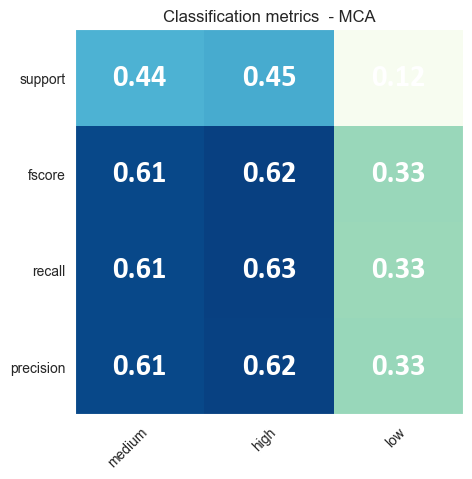

In [68]:
visualize_classification_metrics(test_dataset[goal], svc_pipeline.predict(test_dataset[features]),
                                 labels=labels, name='MCA')

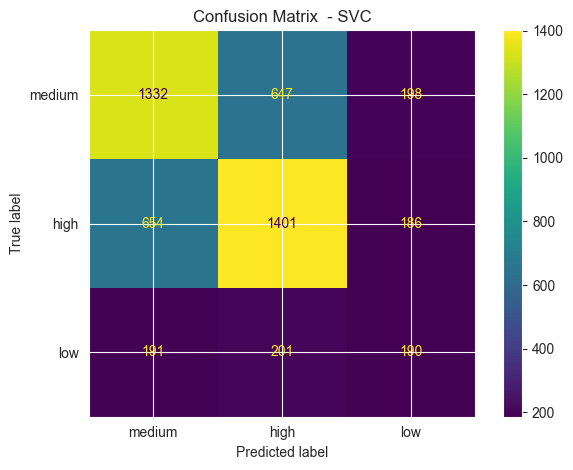

In [69]:
visualize_confusion_matrix(test_dataset[goal], svc_pipeline.predict(test_dataset[features]), labels=labels, name='SVC')

#### Testy dla MCA & SVC

In [182]:
from sklearn.svm import SVC 

dims = [9]
grid_searches = []

for dim in dims:
    mca_features_pipeline = Pipeline([
        ('mca', prince.MCA(
            n_components=dim, 
            n_iter=6,
            copy=True,
            check_input=True,
            engine='sklearn',
            random_state=42)),
        ('scaler', StandardScaler())
    ])
    
    svc_grid_search = GridSearchCV(estimator=SVC(random_state=42),
                      param_grid={
                          'C': [0.1, 1, 2],
                          'kernel': ['linear', 'poly', 'rbf'],
                          'class_weight': ['balanced', None]
                      },
                      scoring=['accuracy', 'balanced_accuracy'], cv=5, verbose=2, refit='balanced_accuracy')
        
    svc_gd_pipeline = Pipeline([
        ('preprocessor', mca_features_pipeline),
        ('classifier', svc_grid_search)
    ])
    
    svc_gd_pipeline.fit(train_dataset[features], mca_train_dataset[goal])
    grid_searches.append(svc_gd_pipeline)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] END ........C=0.1, class_weight=balanced, kernel=linear; total time=   5.0s
[CV] END ........C=0.1, class_weight=balanced, kernel=linear; total time=   4.6s
[CV] END ........C=0.1, class_weight=balanced, kernel=linear; total time=   5.9s
[CV] END ........C=0.1, class_weight=balanced, kernel=linear; total time=   5.4s
[CV] END ........C=0.1, class_weight=balanced, kernel=linear; total time=   5.9s
[CV] END ..........C=0.1, class_weight=balanced, kernel=poly; total time=   3.4s
[CV] END ..........C=0.1, class_weight=balanced, kernel=poly; total time=   4.0s
[CV] END ..........C=0.1, class_weight=balanced, kernel=poly; total time=   4.1s
[CV] END ..........C=0.1, class_weight=balanced, kernel=poly; total time=   3.4s
[CV] END ..........C=0.1, class_weight=balanced, kernel=poly; total time=   3.2s
[CV] END ...........C=0.1, class_weight=balanced, kernel=rbf; total time=   5.4s
[CV] END ...........C=0.1, class_weight=balanced

In [186]:
import pickle 
with open(f'grid-search-{2}.pkl', 'wb') as f:
    pickle.dump(grid_searches[0], f)

In [187]:
import pickle 
grid_searches = []
for i in range(3):
    with open(f'grid-search-{i}.pkl', 'rb') as f:
        gs = pickle.load(f)
        grid_searches.append(gs)

#### Analiza wyników przeszukiwania

MCA posłużyło jako PCA, tylko dla danych kategorialnych. Zostały przetestowane SVC z różnymi rodzajami kernel'i i wartościami regularyzacji, dla dwóch wymiarowości MCA. Najlepsze wartości osiągnął kernel 'rbf', gdzie faworyzowane były przebiegi bez wag dla klas. Warto zauważyć, że zbalansowana dokładność dla wymiarowości 3 jest o wiele gorsza i osiąga  wyniki jak dla losowego klasyfikatora. 

In [188]:
pd.DataFrame.from_dict(grid_searches[0].named_steps['classifier'].cv_results_)[['param_C', 'param_class_weight', 'param_kernel', 'mean_test_accuracy', 'mean_test_balanced_accuracy']]

param_C param_class_weight param_kernel  mean_test_accuracy  \
0       0.1           balanced       linear            0.532867   
1       0.1           balanced         poly            0.570000   
2       0.1           balanced          rbf            0.581000   
3       0.1               None       linear            0.585533   
4       0.1               None         poly            0.607200   
5       0.1               None          rbf            0.650733   
6       1.0           balanced       linear            0.532200   
7       1.0           balanced         poly            0.568600   
8       1.0           balanced          rbf            0.623400   
9       1.0               None       linear            0.585533   
10      1.0               None         poly            0.605800   
11      1.0               None          rbf            0.690000   
12      2.0           balanced       linear            0.532200   
13      2.0           balanced         poly            0.567000   
14      2.0           balanced          rbf            0.637467   
15      2.0               None       linear            0.585533   
16      2.0               None         poly            0.605333   
17      2.0               None          rbf            0.702933   

    mean_test_balanced_accuracy  
0                      0.497749  
1                      0.512184  
2                      0.573451  
3                      0.441853  
4                      0.468678  
5                      0.520536  
6                      0.495829  
7                      0.512655  
8                      0.610847  
9                      0.441853  
10                     0.467641  
11                     0.561463  
12                     0.495829  
13                     0.511411  
14                     0.621180  
15                     0.441853  
16                     0.467284  
17                     0.572244

In [189]:
pd.DataFrame.from_dict(grid_searches[1].named_steps['classifier'].cv_results_)[['param_C', 'param_class_weight', 'param_kernel', 'mean_test_accuracy', 'mean_test_balanced_accuracy']]

param_C param_class_weight param_kernel  mean_test_accuracy  \
0       0.1           balanced       linear            0.490333   
1       0.1           balanced         poly            0.641733   
2       0.1           balanced          rbf            0.729200   
3       0.1               None       linear            0.574467   
4       0.1               None         poly            0.636200   
5       0.1               None          rbf            0.745200   
6       1.0           balanced       linear            0.488067   
7       1.0           balanced         poly            0.643733   
8       1.0           balanced          rbf            0.852667   
9       1.0               None       linear            0.575400   
10      1.0               None         poly            0.641800   
11      1.0               None          rbf            0.850600   
12      2.0           balanced       linear            0.488067   
13      2.0           balanced         poly            0.648733   
14      2.0           balanced          rbf            0.869000   
15      2.0               None       linear            0.575267   
16      2.0               None         poly            0.648867   
17      2.0               None          rbf            0.874267   

    mean_test_balanced_accuracy  
0                      0.508872  
1                      0.652099  
2                      0.758131  
3                      0.433438  
4                      0.545975  
5                      0.662979  
6                      0.507870  
7                      0.660213  
8                      0.867377  
9                      0.434148  
10                     0.558646  
11                     0.822725  
12                     0.507870  
13                     0.663767  
14                     0.882950  
15                     0.434046  
16                     0.567228  
17                     0.859822

In [190]:
pd.DataFrame.from_dict(grid_searches[2].named_steps['classifier'].cv_results_)[['param_C', 'param_class_weight', 'param_kernel', 'mean_test_accuracy', 'mean_test_balanced_accuracy']]

param_C param_class_weight param_kernel  mean_test_accuracy  \
0       0.1           balanced       linear            0.636133   
1       0.1           balanced         poly            0.843867   
2       0.1           balanced          rbf            0.848267   
3       0.1               None       linear            0.692867   
4       0.1               None         poly            0.834800   
5       0.1               None          rbf            0.862933   
6       1.0           balanced       linear            0.635467   
7       1.0           balanced         poly            0.895267   
8       1.0           balanced          rbf            0.952467   
9       1.0               None       linear            0.692533   
10      1.0               None         poly            0.897467   
11      1.0               None          rbf            0.956000   
12      2.0           balanced       linear            0.635467   
13      2.0           balanced         poly            0.912400   
14      2.0           balanced          rbf            0.960867   
15      2.0               None       linear            0.692533   
16      2.0               None         poly            0.911867   
17      2.0               None          rbf            0.963333   

    mean_test_balanced_accuracy  
0                      0.605097  
1                      0.828583  
2                      0.871033  
3                      0.522668  
4                      0.738733  
5                      0.793101  
6                      0.604731  
7                      0.896216  
8                      0.956651  
9                      0.522417  
10                     0.847751  
11                     0.944325  
12                     0.604731  
13                     0.919251  
14                     0.966663  
15                     0.522417  
16                     0.867433  
17                     0.952973

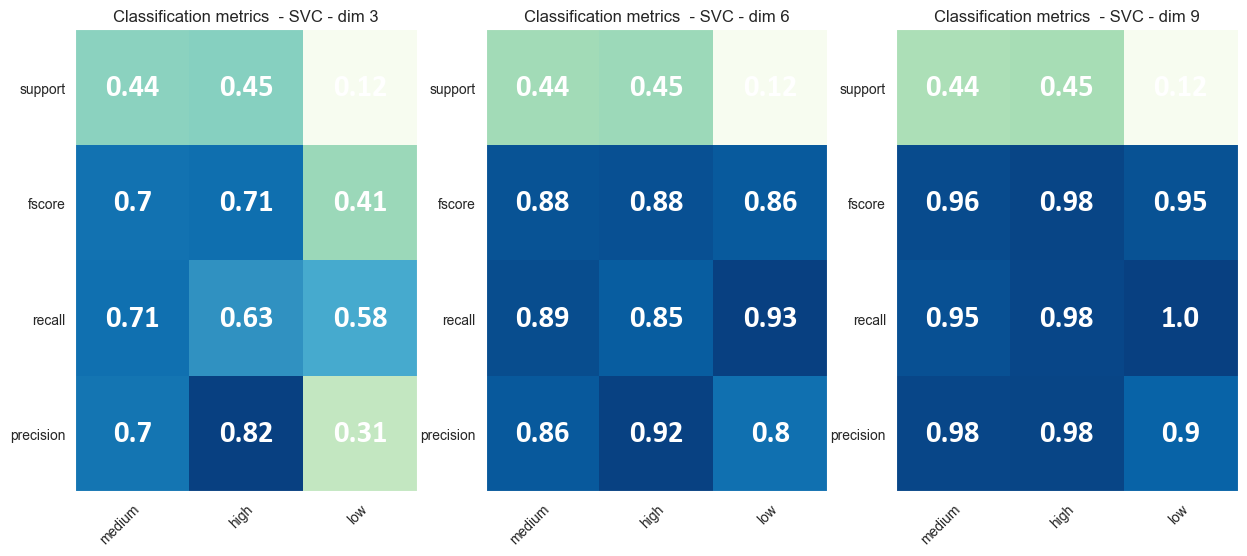

In [193]:
_, axes = plt.subplots(1, 3, figsize=(15, 6))
visualize_classification_metrics(test_dataset[goal], grid_searches[0].predict(test_dataset[features]), 
                                 labels, 'SVC - dim 3', ax=axes[0])
visualize_classification_metrics(test_dataset[goal], grid_searches[1].predict(test_dataset[features]), 
                                 labels, 'SVC - dim 6', ax=axes[1])
visualize_classification_metrics(test_dataset[goal], grid_searches[2].predict(test_dataset[features]), 
                                 labels, 'SVC - dim 9', ax=axes[2])

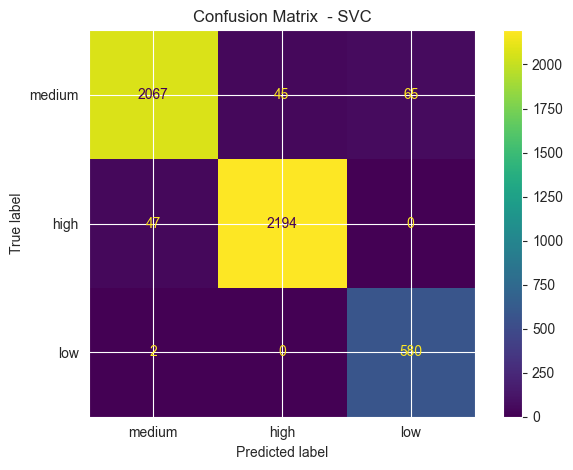

In [194]:
visualize_confusion_matrix(test_dataset[goal], grid_searches[2].predict(test_dataset[features]), 
                                 labels, 'SVC')

### Drzewo losowe 

In [195]:
from sklearn.ensemble import RandomForestClassifier

rdf_grid_search = GridSearchCV(estimator=RandomForestClassifier(),
                  param_grid={
                      'n_estimators': [10, 50, 100],
                      'max_depth': [None, 6, 12],
                      'max_features': [None, 'log2']
                  },
                  scoring=['accuracy', 'balanced_accuracy'], cv=5, verbose=1, refit='balanced_accuracy')

rdf_gs_pipeline = Pipeline([
    ('preprocessor', preprocessing_pipeline),
    ('estimator', rdf_grid_search)
])

rdf_gs_pipeline.fit(train_dataset[features], train_dataset[goal])

Fitting 5 folds for each of 18 candidates, totalling 90 fits


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('nominal_preprocessor',
                                                  Pipeline(steps=[('encoder',
                                                                   OrdinalEncoder())]),
                                                  ['material', 'color', 'size',
                                                   'sleeves'])])),
                ('estimator',
                 GridSearchCV(cv=5, estimator=RandomForestClassifier(),
                              param_grid={'max_depth': [None, 6, 12],
                                          'max_features': [None, 'log2'],
                                          'n_estimators': [10, 50, 100]},
                              refit='balanced_accuracy',
                              scoring=['accuracy', 'balanced_accuracy'],
                              verbose=1))])

In [77]:
rfc_res = pd.DataFrame.from_dict(rdf_gs_pipeline.named_steps['estimator'].cv_results_)

In [78]:
rfc_res.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_max_depth', 'param_max_features', 'param_n_estimators', 'params',
       'split0_test_accuracy', 'split1_test_accuracy', 'split2_test_accuracy',
       'split3_test_accuracy', 'split4_test_accuracy', 'mean_test_accuracy',
       'std_test_accuracy', 'rank_test_accuracy',
       'split0_test_balanced_accuracy', 'split1_test_balanced_accuracy',
       'split2_test_balanced_accuracy', 'split3_test_balanced_accuracy',
       'split4_test_balanced_accuracy', 'mean_test_balanced_accuracy',
       'std_test_balanced_accuracy', 'rank_test_balanced_accuracy'],
      dtype='object')

#### Porównanie wyników 

In [196]:
rfc_res[['param_max_depth', 'param_max_features', 'param_n_estimators', 'mean_test_accuracy', 'mean_test_balanced_accuracy']]

param_max_depth param_max_features  param_n_estimators  \
0               NaN               None                  10   
1               NaN               None                  50   
2               NaN               None                 100   
3               NaN               log2                  10   
4               NaN               log2                  50   
5               NaN               log2                 100   
6               6.0               None                  10   
7               6.0               None                  50   
8               6.0               None                 100   
9               6.0               log2                  10   
10              6.0               log2                  50   
11              6.0               log2                 100   
12             12.0               None                  10   
13             12.0               None                  50   
14             12.0               None                 100   
15             12.0               log2                  10   
16             12.0               log2                  50   
17             12.0               log2                 100   

    mean_test_accuracy  mean_test_balanced_accuracy  
0             0.967000                     0.957995  
1             0.968067                     0.960051  
2             0.967400                     0.959409  
3             0.967267                     0.958027  
4             0.966467                     0.957984  
5             0.967467                     0.959315  
6             0.827400                     0.752842  
7             0.821933                     0.747660  
8             0.826467                     0.757459  
9             0.824133                     0.757423  
10            0.814000                     0.759552  
11            0.810067                     0.751010  
12            0.962867                     0.950175  
13            0.963533                     0.949040  
14            0.962800                     0.950427  
15            0.963600                     0.950920  
16            0.964733                     0.952606  
17            0.964267                     0.950842

## Porównanie algorytmów 

Najlepiej sprawiły się drzewa decyzyjne, co może być związane z tym, że wyczerpuje ono wszystkie możliwe decyzje. W tym przypadku las drzew losowych nie wniósł poprawy. W drugiej kolejności sprawdził się SVC, a potem naiwny bayes

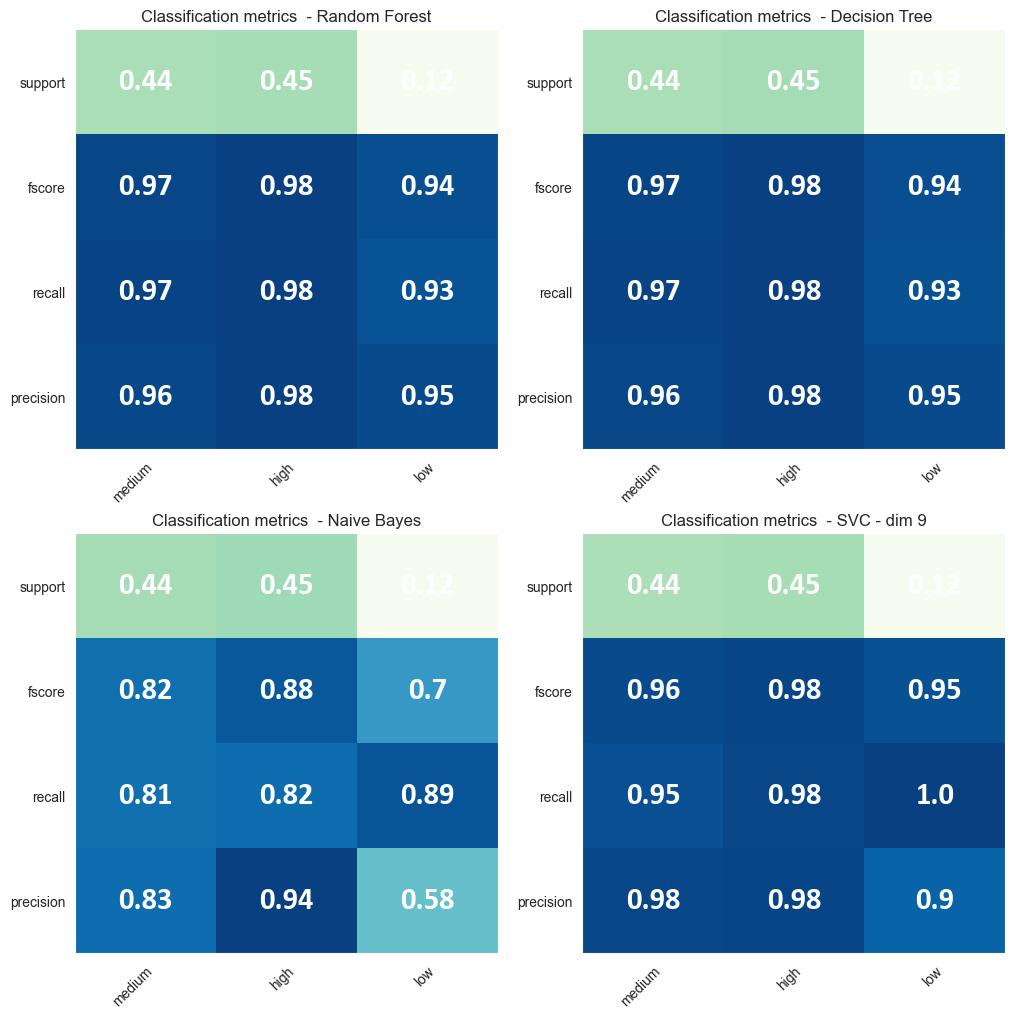

In [197]:
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
visualize_classification_metrics(test_dataset[goal], rdf_gs_pipeline.predict(test_dataset[features]), labels, 'Random Forest', ax=axes[0, 0])
visualize_classification_metrics(test_dataset[goal], dt_clf_gd_pipe.predict(test_dataset[features]), labels, 'Decision Tree', ax=axes[0, 1])
visualize_classification_metrics(test_dataset[goal], cat_nb_gs_pipeline.predict(test_dataset[features]), labels, 'Naive Bayes', ax=axes[1, 0])
visualize_classification_metrics(test_dataset[goal], grid_searches[2].predict(test_dataset[features]), labels, 'SVC - dim 9', ax=axes[1, 1])

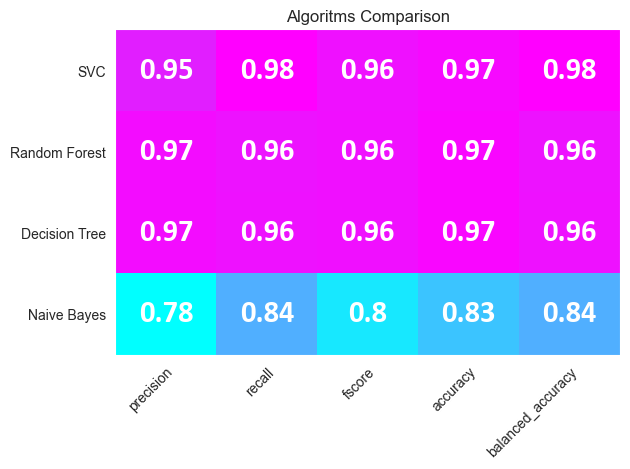

[0.951989882746542,
 0.9750208479963579,
 0.9626075072336278,
 0.9682,
 0.9750208479963579]

In [198]:
visualize_compare_algorithms(
    test_dataset[features], test_dataset[goal],
    [cat_nb_gs_pipeline, dt_clf_gd_pipe, rdf_gs_pipeline, grid_searches[2]],
    ['Naive Bayes', 'Decision Tree', 'Random Forest', 'SVC']
)

In [200]:
melted = long_form_results(test_dataset[features], test_dataset[goal], labels, [cat_nb_gs_pipeline, dt_clf_gd_pipe, rdf_gs_pipeline, grid_searches[2]],
    ['Naive Bayes', 'Decision Tree', 'Random Forest', 'SVC'])

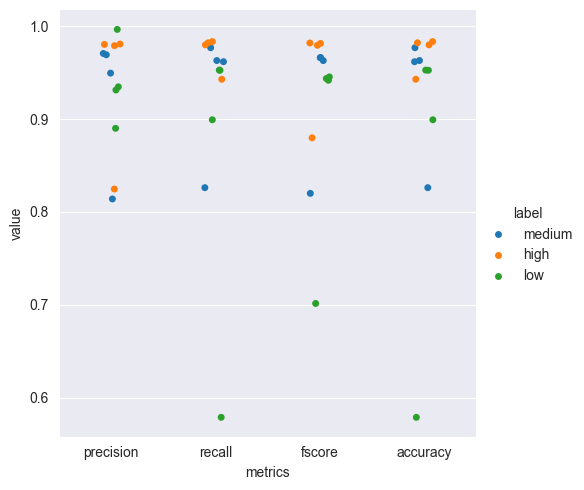

In [201]:
sns.catplot(melted, y='value', x='metrics', hue='label')

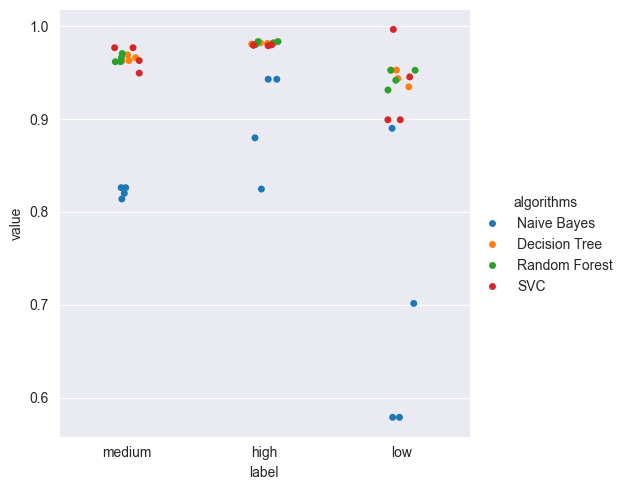

In [202]:
sns.catplot(melted, y='value', x='label', hue='algorithms')

### Radzenie sobie z wartościami brakującymi 

Została wybrana dosyć duża wartość - 50%, ponieważ dla 5% wyniki były praktycznie takie same. Być może wynika to również z tego, że zmienne są niezależne, więc wybranie najczęstszej wartości - bo tak też działa wybrany algorytm uzupełniania danych - sprawdzi się dla każdej wartości atrybutu. 

In [85]:
fraction_missing = 0.5

In [86]:
features_pipeline = Pipeline([
    ('encoder', OrdinalEncoder())
])

preprocessing_pipeline = ColumnTransformer([
    ('nominal_preprocessor', features_pipeline, features)
])

In [87]:
mis_train_features = randomly_mask(train_dataset[features], fraction_missing)

In [88]:
mis_train_features

material   color size sleeves
3152       NaN     NaN   XS     NaN
2950       NaN  violet  XXL     NaN
7761       NaN     NaN    L    long
11332      NaN     NaN    L    long
1172       NaN     NaN  NaN     NaN
...        ...     ...  ...     ...
17606    linen     NaN  NaN     NaN
8605       NaN     NaN    M   short
1078     nylon     NaN  NaN     NaN
8096       NaN   white    L    long
8119     linen     NaN   XL    long

[15000 rows x 4 columns]

In [89]:
np.sum(mis_train_features.isna())

C:\Users\julia\VSCode\AI-and-Data-Engineering\.venv\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


material    7389
color       7520
size        7614
sleeves     7584
dtype: int64

In [90]:
mis_train_features.dtypes

material    object
color       object
size        object
sleeves     object
dtype: object

In [91]:
from sklearn.impute import SimpleImputer

In [92]:
imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
imp_train_features = imp.fit_transform(mis_train_features)

In [93]:
imp_train_features = pd.DataFrame(imp_train_features, columns=features)

In [94]:
imp_train_features.dtypes

material    object
color       object
size        object
sleeves     object
dtype: object

In [95]:
np.sum(imp_train_features.isna())

C:\Users\julia\VSCode\AI-and-Data-Engineering\.venv\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


material    0
color       0
size        0
sleeves     0
dtype: int64

In [96]:
train_dataset[goal]

3152       high
2950     medium
7761     medium
11332    medium
1172     medium
          ...  
17606      high
8605     medium
1078       high
8096       high
8119     medium
Name: demand, Length: 15000, dtype: object

In [97]:
cat_mis_nb_grid_search = GridSearchCV(estimator=CategoricalNB(),
                  param_grid={
                      'fit_prior': [True, False],
                      'class_prior': [None, [0.5, 0.1, 0.4]]
                  },
                  scoring=['accuracy', 'balanced_accuracy'], cv=5, verbose=1, refit='balanced_accuracy')

cat_mis_nb_gs_pipeline = Pipeline([
    ('preprocessor', preprocessing_pipeline),
    ('classifier', cat_mis_nb_grid_search)
])

cat_mis_nb_gs_pipeline.fit(imp_train_features, train_dataset[goal])

Fitting 5 folds for each of 4 candidates, totalling 20 fits


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('nominal_preprocessor',
                                                  Pipeline(steps=[('encoder',
                                                                   OrdinalEncoder())]),
                                                  ['material', 'color', 'size',
                                                   'sleeves'])])),
                ('classifier',
                 GridSearchCV(cv=5, estimator=CategoricalNB(),
                              param_grid={'class_prior': [None,
                                                          [0.5, 0.1, 0.4]],
                                          'fit_prior': [True, False]},
                              refit='balanced_accuracy',
                              scoring=['accuracy', 'balanced_accuracy'],
                              verbose=1))])

In [98]:
cat_mis_res = pd.DataFrame.from_dict(cat_mis_nb_gs_pipeline.named_steps['classifier'].cv_results_)
cat_mis_res[['param_class_prior', 'param_fit_prior', 'mean_test_accuracy', 'mean_test_balanced_accuracy']]

param_class_prior  param_fit_prior  mean_test_accuracy  \
0              None             True            0.612533   
1              None            False            0.566733   
2   [0.5, 0.1, 0.4]             True            0.607400   
3   [0.5, 0.1, 0.4]            False            0.607400   

   mean_test_balanced_accuracy  
0                     0.509145  
1                     0.552291  
2                     0.503641  
3                     0.503641

W przypadku, gdy połowa atrybutów ma wartości brakujące, to naiwny bayes radzi sobie nie najgorzej w przypadku klasy high, która jest najczęściej występująca.  

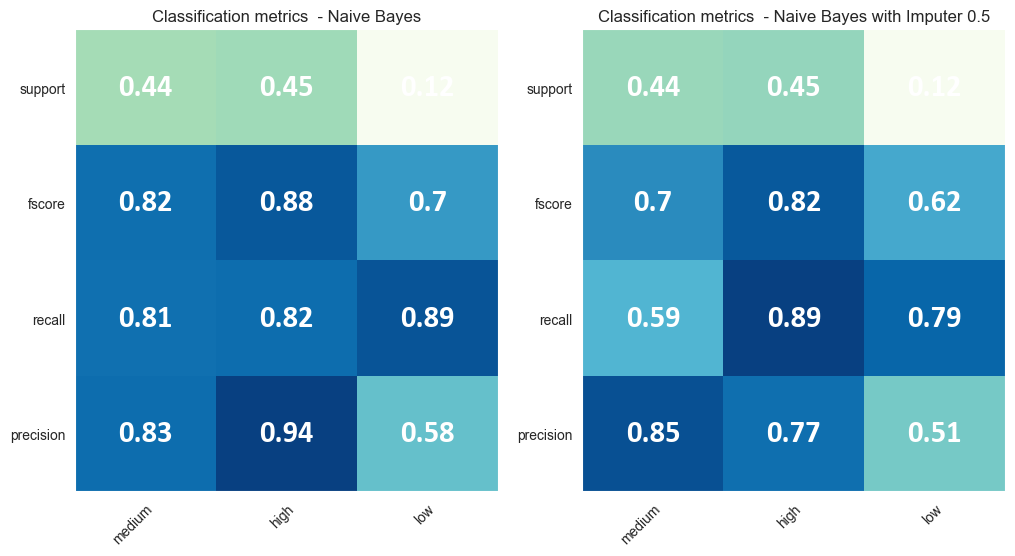

In [99]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
visualize_classification_metrics(test_dataset[goal], cat_nb_gs_pipeline.predict(test_dataset[features]), labels, 'Naive Bayes', ax=axes[0])
visualize_classification_metrics(test_dataset[goal], cat_mis_nb_gs_pipeline.predict(test_dataset[features]), labels, f'Naive Bayes with Imputer {fraction_missing}', ax=axes[1])

In [100]:
from sklearn.tree import DecisionTreeClassifier

dt_clf_mis_grid_search = GridSearchCV(estimator=DecisionTreeClassifier(random_state=42),
                  param_grid={
                      'max_depth': [None, 6, 12],
                      'min_samples_leaf': [1, 2, 5],
                      'max_features': [None, 'log2']
                  },
                  scoring=['accuracy', 'balanced_accuracy'], cv=5, verbose=1, refit='balanced_accuracy')

dt_clf_mis_gd_pipe = Pipeline([
    ('preprocessor', preprocessing_pipeline),
    ('estimator', dt_clf_mis_grid_search)
])

dt_clf_mis_gd_pipe.fit(imp_train_features, train_dataset[goal])

Fitting 5 folds for each of 18 candidates, totalling 90 fits


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('nominal_preprocessor',
                                                  Pipeline(steps=[('encoder',
                                                                   OrdinalEncoder())]),
                                                  ['material', 'color', 'size',
                                                   'sleeves'])])),
                ('estimator',
                 GridSearchCV(cv=5,
                              estimator=DecisionTreeClassifier(random_state=42),
                              param_grid={'max_depth': [None, 6, 12],
                                          'max_features': [None, 'log2'],
                                          'min_samples_leaf': [1, 2, 5]},
                              refit='balanced_accuracy',
                              scoring=['accuracy', 'balanced_accuracy'],
                              verbose=1))])

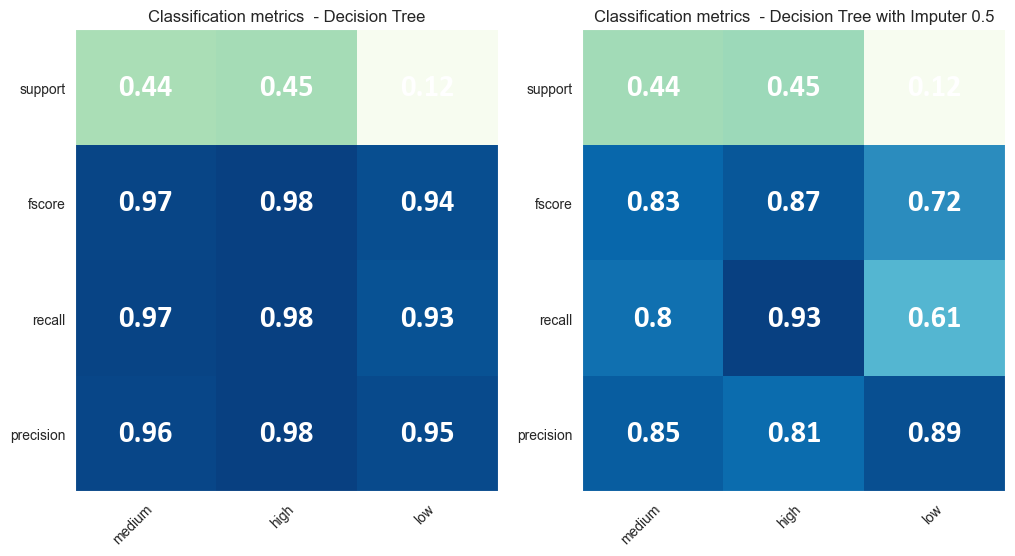

In [101]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
visualize_classification_metrics(test_dataset[goal], dt_clf_gd_pipe.predict(test_dataset[features]), labels, 'Decision Tree', ax=axes[0])
visualize_classification_metrics(test_dataset[goal], dt_clf_mis_gd_pipe.predict(test_dataset[features]), labels, f'Decision Tree with Imputer {fraction_missing}', ax=axes[1])